# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, layers, losses, Model

import tfomics
from tfomics import moana, impress
from tfomics.layers import MultiHeadAttention

import matplotlib.pyplot as plt

import os, shutil
import ushuffle

import requests as rq
import h5py, io

import utils
import models

owd = os.getcwd()

# Load data

In [2]:
file_path = 'synthetic_interactions_dataset.h5'

with h5py.File(file_path, 'r') as dataset:
    X = np.array(dataset['X'])
    Y = np.array(dataset['Y'])
    L = np.array(dataset['L'])
    
train = int(len(X) * 0.7)
valid = train + int(len(X) * 0.1 )
test = valid + int(len(X) * 0.2)

x_train = X[:train]
x_valid = X[train:valid]
x_test = X[valid:test]

y_train = Y[:train]
y_valid = Y[train:valid]
y_test = Y[valid:test]

# Define model

In [3]:
model = models.CNN_ATT(
    in_shape=(200, 4),
    num_filters=32,
    batch_norm=False,
    activation='relu',
    pool_size=40,
    layer_norm=False,
    heads=1,
    vector_size=32,
    layer_norm_after=False,
    dense_units=64,
    num_out=12
)

In [4]:
lays = [type(i) for i in model.layers]
c_index = lays.index(tf.keras.layers.MaxPool1D)
mha_index = lays.index(tfomics.layers.MultiHeadAttention)

# Train model

In [5]:
auroc = tf.keras.metrics.AUC(curve='ROC', name='auroc')
aupr = tf.keras.metrics.AUC(curve='PR', name='aupr')
model.compile(
    tf.keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=[auroc, aupr]
)
batch_size = 256

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patient=5, verbose=1, min_lr=1e-7, mode='min')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)
model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), callbacks=[lr_decay, early_stop], verbose=1, batch_size=batch_size)

Epoch 1/100
274/274 [==============================] - 2s 6ms/step - loss: 0.4525 - auroc: 0.6161 - aupr: 0.1994 - val_loss: 0.4165 - val_auroc: 0.8325 - val_aupr: 0.5551
Epoch 2/100
274/274 [==============================] - 1s 4ms/step - loss: 0.2718 - auroc: 0.8647 - aupr: 0.6101 - val_loss: 0.1982 - val_auroc: 0.9685 - val_aupr: 0.8502
Epoch 3/100
274/274 [==============================] - 1s 4ms/step - loss: 0.2046 - auroc: 0.9308 - aupr: 0.7625 - val_loss: 0.1330 - val_auroc: 0.9806 - val_aupr: 0.9048
Epoch 4/100
274/274 [==============================] - 1s 4ms/step - loss: 0.1850 - auroc: 0.9427 - aupr: 0.8004 - val_loss: 0.1193 - val_auroc: 0.9838 - val_aupr: 0.9171
Epoch 5/100
274/274 [==============================] - 1s 4ms/step - loss: 0.1756 - auroc: 0.9484 - aupr: 0.8183 - val_loss: 0.1125 - val_auroc: 0.9854 - val_aupr: 0.9297
Epoch 6/100
274/274 [==============================] - 1s 4ms/step - loss: 0.1687 - auroc: 0.9526 - aupr: 0.8307 - val_loss: 0.1065 - val_auroc: 

Epoch 49/100
274/274 [==============================] - 1s 4ms/step - loss: 0.1323 - auroc: 0.9706 - aupr: 0.8911 - val_loss: 0.0838 - val_auroc: 0.9899 - val_aupr: 0.9532
Epoch 50/100
274/274 [==============================] - 1s 4ms/step - loss: 0.1327 - auroc: 0.9704 - aupr: 0.8907 - val_loss: 0.0872 - val_auroc: 0.9890 - val_aupr: 0.9508
Epoch 51/100
274/274 [==============================] - 1s 4ms/step - loss: 0.1335 - auroc: 0.9699 - aupr: 0.8897 - val_loss: 0.0849 - val_auroc: 0.9891 - val_aupr: 0.9523
Epoch 52/100
274/274 [==============================] - 1s 4ms/step - loss: 0.1315 - auroc: 0.9708 - aupr: 0.8925 - val_loss: 0.0849 - val_auroc: 0.9889 - val_aupr: 0.9538
Epoch 53/100
274/274 [==============================] - 1s 4ms/step - loss: 0.1320 - auroc: 0.9705 - aupr: 0.8919 - val_loss: 0.0855 - val_auroc: 0.9895 - val_aupr: 0.9528
Epoch 54/100
266/274 [============================>.] - ETA: 0s - loss: 0.1317 - auroc: 0.9707 - aupr: 0.8921
Epoch 00054: ReduceLROnPlateau

274/274 [==============================] - 1s 4ms/step - loss: 0.1267 - auroc: 0.9728 - aupr: 0.8993 - val_loss: 0.0825 - val_auroc: 0.9894 - val_aupr: 0.9550
Epoch 95/100
274/274 [==============================] - 1s 5ms/step - loss: 0.1278 - auroc: 0.9723 - aupr: 0.8976 - val_loss: 0.0827 - val_auroc: 0.9893 - val_aupr: 0.9548
Epoch 96/100
267/274 [============================>.] - ETA: 0s - loss: 0.1270 - auroc: 0.9727 - aupr: 0.8989
Epoch 00096: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
274/274 [==============================] - 1s 5ms/step - loss: 0.1271 - auroc: 0.9727 - aupr: 0.8990 - val_loss: 0.0824 - val_auroc: 0.9895 - val_aupr: 0.9548
Epoch 97/100
274/274 [==============================] - 1s 5ms/step - loss: 0.1272 - auroc: 0.9728 - aupr: 0.8983 - val_loss: 0.0825 - val_auroc: 0.9894 - val_aupr: 0.9548
Epoch 98/100
274/274 [==============================] - 1s 4ms/step - loss: 0.1270 - auroc: 0.9728 - aupr: 0.8986 - val_loss: 0.0825 - val_auroc: 0.

# Model classification performance

In [6]:
loss, auc_roc, auc_pr = model.evaluate(x_test, y_test)

625/625 [==============================] - 1s 2ms/step - loss: 0.0833 - auroc: 0.9890 - aupr: 0.9554


In [7]:
classes = ['ELF', 'SIX', 'ESR', 'FOXN', 'CEBPB', 'YY', 'GATA', 'IRF', 'SP', 'NFIB', 'TEAD', 'TAL']


import sklearn

u, counts = np.unique(np.where(Y == 1)[1], return_counts=True)
class_balance = counts/len(Y)

y_preds = model.predict(x_test)
for i in range(y_preds.shape[1]):
    
    y_pred = y_preds[:,i]
    y_true = y_test[:,i]
    
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_pred)
    auc = sklearn.metrics.auc(recall, precision)
    print()
    print(f'{classes[i]} \t AUC PR {auc:.3f} \t Weightage {class_balance[i]:.3f}')


ELF 	 AUC PR 0.964 	 Weightage 0.164

SIX 	 AUC PR 0.964 	 Weightage 0.164

ESR 	 AUC PR 0.958 	 Weightage 0.102

FOXN 	 AUC PR 0.954 	 Weightage 0.102

CEBPB 	 AUC PR 0.921 	 Weightage 0.143

YY 	 AUC PR 0.954 	 Weightage 0.144

GATA 	 AUC PR 0.928 	 Weightage 0.162

IRF 	 AUC PR 0.997 	 Weightage 0.101

SP 	 AUC PR 0.996 	 Weightage 0.102

NFIB 	 AUC PR 0.990 	 Weightage 0.142

TEAD 	 AUC PR 0.896 	 Weightage 0.143

TAL 	 AUC PR 0.928 	 Weightage 0.162


# Filter interpretability

In [8]:
ppms = utils.get_ppms(model, x_test)

if os.path.exists('test'):
    shutil.rmtree('test')
os.mkdir('test')
    
moana.meme_generate(ppms, output_file='test/motif.txt')

In [9]:
utils.tomtom('test/motif.txt', 'test/tomtom')


In [20]:
names = ['ELF1', 'SIX3', 'ESR1', 'FOXN', 'CEBPB', 'YY1', 'GATA1', 'IRF1', 'SP1', 'NFIB', 'TEAD', 'TAL1']
jaspar_ids = [utils.elf, utils.six, utils.esr, utils.foxn, utils.cebpb, utils.yy1, utils.gata, utils.irf, utils.sp1, utils.nfib, utils.tead, utils.tal]

match_fraction, match_any, filter_match, filter_qvalue, min_qvalue, num_counts, coverage = utils.get_tomtom_stats('test/tomtom/tomtom.tsv', 32)
filter_matches = np.array(filter_match)
tomtom_tpr = match_fraction
tomtom_fpr = match_any - match_fraction
tomtom_cov = coverage
qvals = filter_qvalue


print('TomTom TPR: ', tomtom_tpr)
print('TomTom FPR: ', tomtom_fpr)
print('Motif coverage: ', tomtom_cov)
print(qvals)

TomTom TPR:  0.875
TomTom FPR:  0.0625
Motif coverage:  1.0
[5.96391e-16 4.75918e-25 1.78010e-38 6.26669e-05 2.65330e-12 3.35881e-18
 3.98039e-06 2.03574e-24 6.59031e-33 3.55824e-29 2.85249e-07 5.98697e-09]


In [11]:
ppm_size = 25
filter_ppms = []
for i in range(len(ppms)):
    padded = np.vstack([ppms[i], np.zeros((ppm_size-len(ppms[i]), 4))+0.25])
    filter_ppms.append(padded)
filter_ppms = np.array(filter_ppms)

information = []
for i in range(len(filter_ppms)):
    I = np.log2(4) + np.sum(filter_ppms[i] * np.log2(filter_ppms[i] + 1e-7), axis=1)
    information.append(I)
information = np.sum(information, axis=1)

good_filters = np.where(information > 0.5)[0]

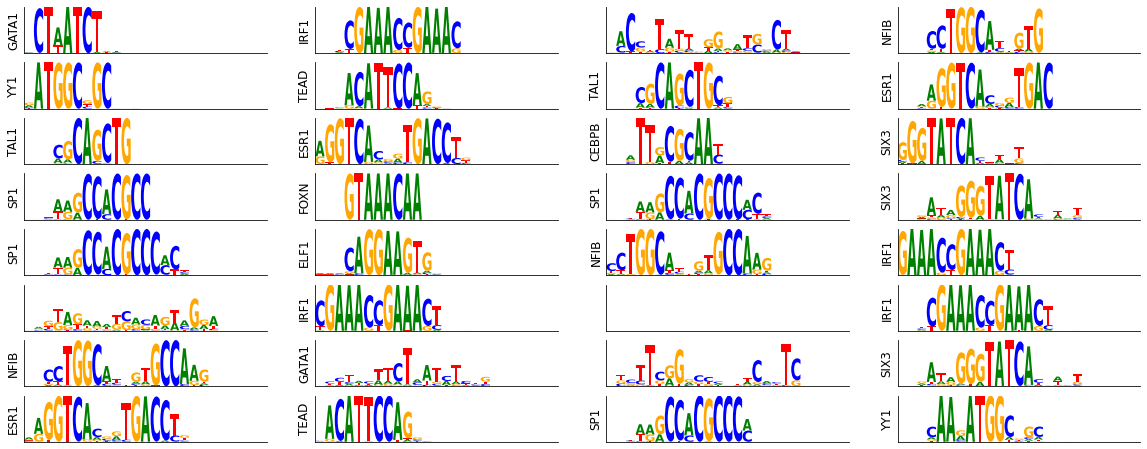

In [12]:
import logomaker
import pandas as pd

def plot_filters(W, fig, num_cols=8, alphabet='ACGT', names=None, fontsize=12):
    """plot 1st layer convolutional filters"""

    num_filter, filter_len, A = W.shape
    num_rows = np.ceil(num_filter/num_cols).astype(int)

    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    for n, w in enumerate(W):
        ax = fig.add_subplot(num_rows,num_cols,n+1)

        # Calculate sequence logo heights -- information
        I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
        logo = I*w

        # Create DataFrame for logomaker
        counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(filter_len)))
        for a in range(A):
            for l in range(filter_len):
                counts_df.iloc[l,a] = logo[l,a]

        logomaker.Logo(counts_df, ax=ax)
        ax = plt.gca()
        ax.set_ylim(0,2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        if names is not None:
            plt.ylabel(names[n], fontsize=fontsize)

fig = plt.figure(figsize=(20, model.layers[1].get_weights()[0].shape[-1]//4))

ppm_size = 25
filter_ppms = []
for i in range(len(ppms)):
    padded = np.vstack([ppms[i], np.zeros((ppm_size-len(ppms[i]), 4))+0.25])
    filter_ppms.append(padded)
filter_ppms = np.array(filter_ppms)

plot_filters(filter_ppms, fig, num_cols=4, names=filter_matches)

# Clustering

In [13]:
feature_maps = utils.get_layer_output(model, c_index, x_test)

order = np.argsort((filter_matches == '').astype(int))
fmaps = feature_maps.transpose()[order].transpose()
filter_labels = filter_matches[order]
junk_cutoff = np.where((filter_labels == '').astype(int) == 0)[0]
if len(junk_cutoff) > 0:
    junk_cutoff = junk_cutoff[-1]+1
else:
    junk_cutoff = len(filter_labels)

c_fmaps = fmaps.transpose()[:junk_cutoff].transpose()
c_filter_labels = filter_labels[:junk_cutoff]
labels, labels_order, Z, groups, group_names, clustered_fmaps = utils.hierarchichal_clustering(c_fmaps, 0.7, c_filter_labels)

fmaps = np.vstack([c_fmaps.transpose()[labels_order], fmaps.transpose()[junk_cutoff:]]).transpose()
filter_labels_ordered = np.concatenate([c_filter_labels[labels_order], filter_labels[junk_cutoff:]])

reorder = np.argsort(filter_labels_ordered[:junk_cutoff])
fmaps = np.vstack([fmaps.transpose()[reorder], fmaps.transpose()[junk_cutoff:]]).transpose()
filter_labels_ordered = np.concatenate([filter_labels_ordered[reorder], filter_labels_ordered[junk_cutoff:]])

ppm_size = 25
filter_ppms = []
for i in range(len(ppms)):
    padded = np.vstack([ppms[i], np.zeros((ppm_size-len(ppms[i]), 4))+0.25])
    filter_ppms.append(padded)
filter_ppms = np.array(filter_ppms)

filter_ppms = np.concatenate([filter_ppms[order][:junk_cutoff][labels_order][reorder], filter_ppms[order][junk_cutoff:]])

information = []
for i in range(len(filter_ppms)):
    I = np.log2(4) + np.sum(filter_ppms[i] * np.log2(filter_ppms[i] + 1e-7), axis=1)
    information.append(I)
information = np.sum(information, axis=1)

good_filters = np.where(information > 0.5)[0]

corr_fmaps = fmaps.transpose()[good_filters].transpose()
corr_filter_labels_ordered = filter_labels_ordered[good_filters]

# SATORI interpretability

In [14]:
sample = x_test[:2000]

feature_maps = fmaps[:len(sample)]
num_filters = feature_maps.shape[2]
print('predicted feature maps')

filter_activations = utils.get_filter_activations(model, c_index, sample)
filter_activations = tf.math.reduce_max(filter_activations, axis=-1)/2
filter_activations = filter_activations.numpy()
filter_activations = np.concatenate([filter_activations[order][:junk_cutoff][labels_order], filter_activations[order][junk_cutoff:]])
print('computed filter activations')

mha_input = utils.get_layer_output(model, mha_index-1, sample)
q, k = utils.get_queries_keys(model, mha_index, mha_input)
print('obtained keys and queries')

att_maps = utils.get_attention_maps(q, k, concat=tf.math.reduce_max).numpy()
for i in range(len(att_maps)):
    np.fill_diagonal(att_maps[i], 0)

thresh = 0.1
position_interactions = utils.get_position_interactions(att_maps, thresh, limit=100000)
print('found position interactions')

filter_interactions = utils.get_filter_interactions(feature_maps, position_interactions, filter_activations)
print('converted to filter interactions\n')

motif_interactions = utils.get_motif_interactions(filter_interactions, filter_labels_ordered)
expecteds = [['ELF1', 'SIX3'], ['ESR1', 'FOXN'], ['GATA1', 'TAL1'], ['IRF1', 'SP1']]

ppv, fpr, tpr = utils.get_interaction_stats(motif_interactions, expecteds)

print(f'PPV {ppv} | TPR {tpr} | FPR {fpr}')

filter_map = (np.arange(num_filters ** 2) * 0).reshape((num_filters, num_filters))
for j in range(len(filter_interactions)):
    filter_map[filter_interactions[j][0], filter_interactions[j][1]] += 1
filter_map = np.array(filter_map)
filter_map = np.amax([filter_map, filter_map.transpose()], axis=0)

ind = np.array(np.tril_indices(len(filter_map), k=-1)).transpose()
motif_interactions = filter_labels_ordered[ind]
filter_interactions_values = filter_map[ind.transpose().tolist()]
mask = ~(motif_interactions.transpose() == motif_interactions.transpose()[::-1])[0]
motif_interactions = motif_interactions[mask]
filter_interactions_values = filter_interactions_values[mask]
motif_interactions.sort()

matches = []
for i in range(len(expecteds)):
    match = (expecteds[i] == motif_interactions).astype(int).transpose()
    match = match[0] * match[1]
    matches.append(match)
TPs = np.amax(matches, axis=0).astype(bool)

trues = filter_interactions_values[TPs]
falses = filter_interactions_values[~TPs]

k = 100
signal = np.mean(trues)
noise = np.sort(falses)[::-1][:k]
noise = noise[np.where(noise > 0)]
noise = np.mean(noise)
snr = signal/(noise + np.finfo(float).eps)

y_pred = np.hstack([trues, falses])
y_true = np.hstack([np.ones(trues.shape), np.zeros(falses.shape)])
precision, recall, ts = sklearn.metrics.precision_recall_curve(y_true, y_pred)
satori_pr = sklearn.metrics.auc(recall, precision)
specificity, sensitivity, ts = sklearn.metrics.roc_curve(y_true, y_pred)
satori_roc = sklearn.metrics.auc(specificity, sensitivity)

print(f'AUPR {satori_pr} | AUROC {satori_roc} | SNR {snr}')

print('finished interpretability')

predicted feature maps
computed filter activations
obtained keys and queries
found position interactions


/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:138: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  vector_interactions = adj_fmaps[position_interactions]


converted to filter interactions

PPV 0.14038071481663456 | TPR 1.0 | FPR 0.8596192851833655
AUPR 0.33908034038957385 | AUROC 0.9470825302260383 | SNR 1.3020423285323948
finished interpretability


<ipython-input-14-fd9a0b70d161>:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = filter_map[ind.transpose().tolist()]


# Correlation map interpretability

In [15]:
# dinuc shuffle

alphabet = np.array([b'A', b'C', b'G', b'T'])

seqs = np.where(x_test == 1)[2].reshape(x_test.shape[:2])
seqs = alphabet[seqs]

N = 20000
sample = 2000

alphabet = ['A', 'C', 'G', 'T']
shuffled_seqs = []
for i in range(len(seqs)):
    seq = seqs[i].tobytes()
    for j in range(N // len(seqs)):
        shuffled = ushuffle.shuffle(seq, 2).decode('UTF-8')
        newseq = np.zeros((len(shuffled), 4))
        ones = [alphabet.index(shuffled[k]) for k in range(len(shuffled))]
        pos = np.arange(len(shuffled))
        newseq[pos, ones] = 1
        shuffled_seqs.append(newseq)
shuffled_seqs = np.array(shuffled_seqs)
np.random.shuffle(shuffled_seqs)
shuffled_seqs = shuffled_seqs[:sample]

# Get feature maps
feature_maps = utils.get_layer_output(model, c_index, shuffled_seqs)
num_filters = feature_maps.shape[2]
print('obtained feature maps')
# Get key and queries
q, k = utils.get_queries_keys(model, mha_index, utils.get_layer_output(model, mha_index-1, shuffled_seqs))
print('computed keys and queries')
# Compute attention map
att_maps = utils.get_attention_maps(q, k, concat=tf.math.reduce_max)
print('generated attention maps')
# Flatten
dinuc_attention_values = tf.reshape(att_maps, -1).numpy()
dinuc_attention_values.sort()

significance = np.percentile(dinuc_attention_values, 90)
print('significance: ', significance)

obtained feature maps
computed keys and queries
generated attention maps
significance:  0.21408125609159467


In [16]:
plt.rcParams["figure.figsize"] = (10, 10)
corr_thresh = 0.1
sample = x_test[:2000]

thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
topNs = [5, 10, 15, 20, 25, 30, 40, 50, 100, 150, 200]
expecteds = [
    ['ELF1', 'SIX3'],
    ['GATA1', 'TAL1'],
    ['ESR1', 'FOXN'],
    ['IRF1', 'SP1']
]

feature_maps = corr_fmaps[:len(sample)]
num_filters = feature_maps.shape[2]

mha_input = utils.get_layer_output(model, mha_index-1, sample)
q, k = utils.get_queries_keys(model, mha_index, mha_input)
att_maps = utils.get_attention_maps(q, k, concat=tf.math.reduce_max).numpy()

for i in range(len(att_maps)):
    np.fill_diagonal(att_maps[i], 0)

all_attention_values = np.reshape(att_maps, -1)

# Normal Correlation maps
correlation_tprs = []
correlation_fprs = []
correlation_covs = []
correlation_aurocs = []
correlation_auprs = []
correlation_snrs = []
for i in range(len(thresholds)):
    print(i/len(thresholds) * 100)
    
    correlation_tprs.append([])
    correlation_fprs.append([])
    correlation_covs.append([])

    if thresholds[i] > np.sort(all_attention_values)[-2]:
        correlation_map = np.zeros((feature_maps.shape[2], feature_maps.shape[2]))
        corr_tpr = 0
        corr_fpr = 0
        corr_cov = 0
    else:
        correlation_map, correlation_interactions, corr_tpr, corr_fpr, corr_cov = utils.get_correlation_stats(feature_maps, att_maps, thresholds[i], corr_filter_labels_ordered, expecteds, corr_thresh, limit=150000, rand=0.5)

    filter_interactions_values = correlation_map.reshape(-1)
    filter_interactions = np.array(np.meshgrid(np.arange(len(correlation_map)), np.arange(len(correlation_map)))).reshape((2, -1))[::-1].transpose()
    order1 = np.argsort(filter_interactions_values)[::-1]
    filter_interactions = filter_interactions[order1]
    filter_interactions_values = filter_interactions_values[order1]
    filter_interactions = filter_interactions[np.where(filter_interactions_values > 0)[0]]
        
    for j in range(len(topNs)):
        
        N = topNs[j]
        correlation_interactions = utils.get_motif_interactions(filter_interactions, corr_filter_labels_ordered)
        mask = ~(correlation_interactions.transpose() == correlation_interactions.transpose()[::-1])[0]
        correlation_interactions = correlation_interactions[mask][:N]
        corr_tpr, corr_fpr, corr_cov = utils.get_interaction_stats(correlation_interactions, expecteds)
        
        correlation_tprs[i].append(corr_tpr)
        correlation_fprs[i].append(corr_fpr)
        correlation_covs[i].append(corr_cov)
    
    ind = np.array(np.tril_indices(len(correlation_map), k=-1)).transpose()
    motif_interactions = corr_filter_labels_ordered[ind]
    filter_interactions_values = correlation_map[ind.transpose().tolist()]
    mask = ~(motif_interactions.transpose() == motif_interactions.transpose()[::-1])[0]
    motif_interactions = motif_interactions[mask]
    filter_interactions_values = filter_interactions_values[mask]
    motif_interactions.sort()

    matches = []
    for k in range(len(expecteds)):
        match = (expecteds[k] == motif_interactions).astype(int).transpose()
        match = match[0] * match[1]
        matches.append(match)
    TPs = np.amax(matches, axis=0).astype(bool)

    trues = filter_interactions_values[TPs]
    falses = filter_interactions_values[~TPs]

    k = 100
    signal = np.mean(trues)
    noise = np.sort(falses)[::-1][:k]
    noise = noise[np.where(noise > 0)]
    noise = np.mean(noise)
    snr = signal/(noise + np.finfo(float).eps)

    y_pred = np.hstack([trues, falses])
    y_true = np.hstack([np.ones(trues.shape), np.zeros(falses.shape)])
    precision, recall, ts = sklearn.metrics.precision_recall_curve(y_true, y_pred)
    corr_pr = sklearn.metrics.auc(recall, precision)
    specificity, sensitivity, ts = sklearn.metrics.roc_curve(y_true, y_pred)
    corr_roc = sklearn.metrics.auc(specificity, sensitivity)
    
    correlation_aurocs.append(corr_roc)
    correlation_auprs.append(corr_pr)
    correlation_snrs.append(snr)
    
correlation_tprs = np.array(correlation_tprs)
correlation_fprs = np.array(correlation_fprs)
correlation_covs = np.array(correlation_covs)
correlation_aurocs = np.array(correlation_aurocs)
correlation_auprs = np.array(correlation_auprs)
correlation_snrs = np.array(correlation_snrs)

0.0


/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_interactions].transpose([1, 2, 0])
<ipython-input-16-9a8383aaa270>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]
/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexin

10.0


<ipython-input-16-9a8383aaa270>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]
/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_interactions].transpose([1, 2, 0])


20.0


<ipython-input-16-9a8383aaa270>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]
/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_interactions].transpose([1, 2, 0])


30.0


<ipython-input-16-9a8383aaa270>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]
/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_interactions].transpose([1, 2, 0])


40.0


<ipython-input-16-9a8383aaa270>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]
/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_interactions].transpose([1, 2, 0])


50.0


<ipython-input-16-9a8383aaa270>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]
/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_interactions].transpose([1, 2, 0])


60.0


<ipython-input-16-9a8383aaa270>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]
/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_interactions].transpose([1, 2, 0])


70.0
80.0
90.0


<ipython-input-16-9a8383aaa270>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]
<ipython-input-16-9a8383aaa270>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid valu

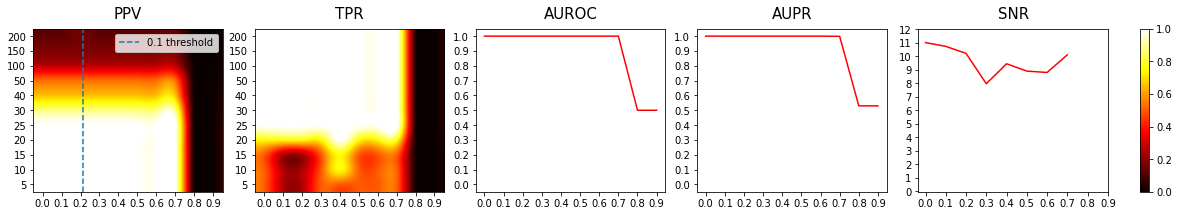

In [17]:
fig = plt.figure(figsize=(20, 3))
ax = fig.subplots(1, 6, gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0.05]})

color = 'hot'
smoothing = 'spline36' # lanczos

ax[0].set_title('PPV', fontsize=15, pad=10)
ax[0].set_xticks(np.arange(len(thresholds)))
ax[0].set_xticklabels(thresholds)
ax[0].set_yticks(np.arange(len(topNs)))
ax[0].set_yticklabels(topNs[::-1], fontsize=10)
c = ax[0].imshow(correlation_tprs.transpose()[::-1], cmap=color, interpolation=smoothing, vmin=0, vmax=1, aspect='auto')
ax[0].axvline(significance*10, linestyle='--', label='0.1 threshold')
ax[0].legend(loc='upper right')

ax[1].set_title('TPR', fontsize=15, pad=10)
ax[1].set_xticks(np.arange(len(thresholds)))
ax[1].set_xticklabels(thresholds)
ax[1].set_yticks(np.arange(len(topNs)))
ax[1].set_yticklabels(topNs[::-1], fontsize=10)
c = ax[1].imshow(correlation_covs.transpose()[::-1], cmap=color, interpolation=smoothing, vmin=0, vmax=1, aspect='auto')

ax[2].set_title('AUROC', fontsize=15, pad=10)
ax[2].plot(thresholds, correlation_aurocs, color='red')
ax[2].set_xticks(thresholds)
ax[2].set_ylim([-0.05, 1.05])
ax[2].set_yticks(np.arange(0.0, 1.1, 0.1))

ax[3].set_title('AUPR', fontsize=15, pad=10)
ax[3].plot(thresholds, correlation_auprs, color='red')
ax[3].set_xticks(thresholds)
ax[3].set_ylim([-0.05, 1.05])
ax[3].set_yticks(np.arange(0.0, 1.1, 0.1))

ax[4].set_title('SNR', fontsize=15, pad=10)
ax[4].plot(thresholds, correlation_snrs, color='red')
ax[4].set_xticks(thresholds)
ax[4].set_ylim([-0.05, 12.05])
ax[4].set_yticks(np.arange(0, 13, 1))

fig.colorbar(c, cax=ax[5])

/home/koolab/Documents/ConvolutionalAttention/Paper_Results/CorrelationDesignSearch/utils.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_interactions].transpose([1, 2, 0])
<ipython-input-18-7d5b6b15683f>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions_values = correlation_map[ind.transpose().tolist()]


 thresh 0.1 	 top 15 
 PPV 1.00 	 TPR 0.50 	 SNR 11.19 
 AUPR 1.00 	 AUROC 1.00
186


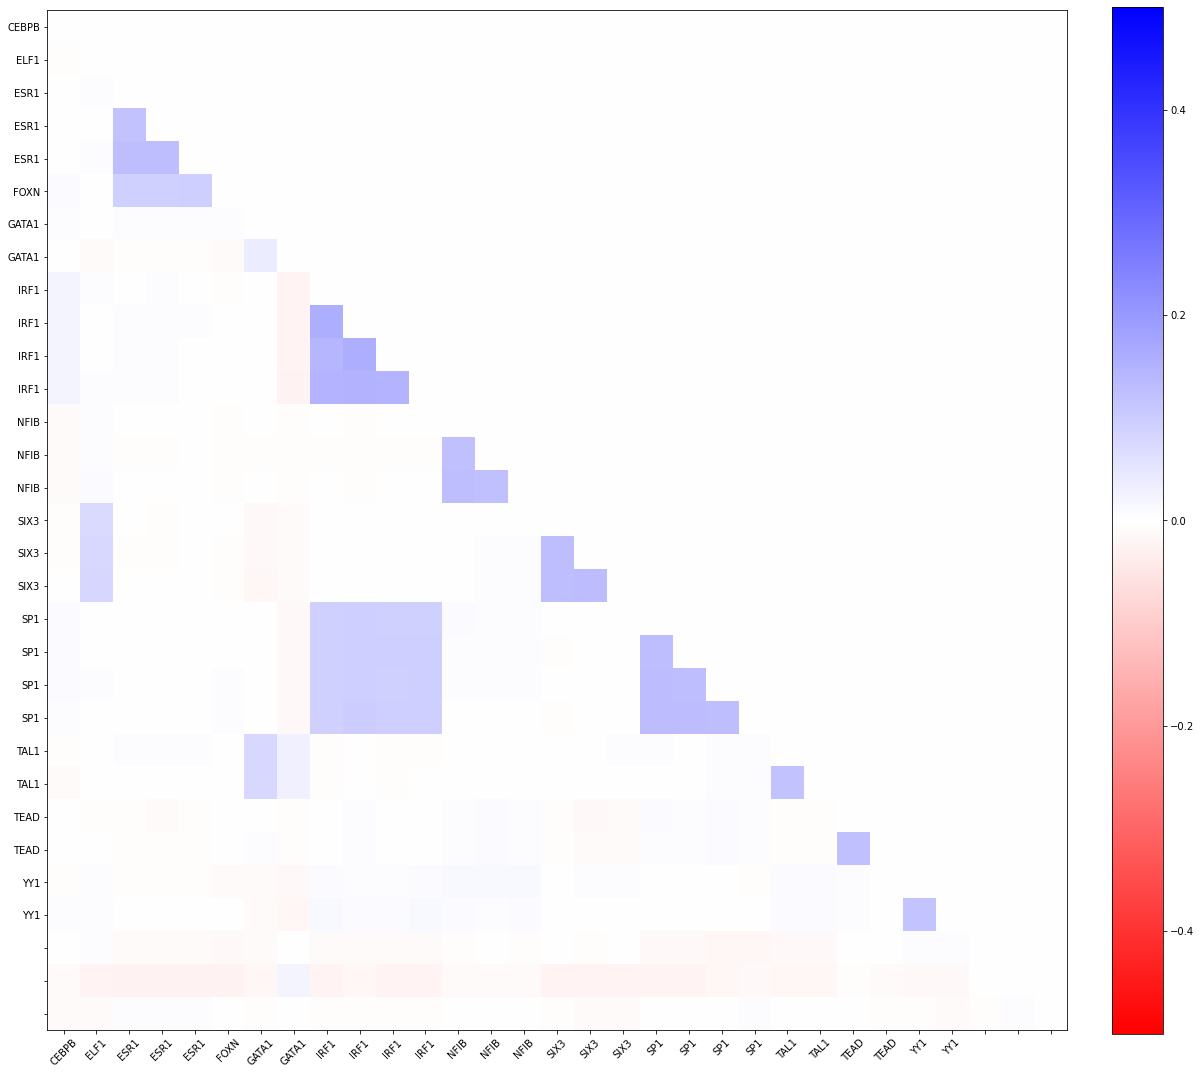

In [18]:
t = 0.1
N = 15

correlation_map, correlation_interactions, corr_tpr, corr_fpr, corr_cov = utils.get_correlation_stats(corr_fmaps, att_maps, t, corr_filter_labels_ordered, expecteds, 0.1, limit=150000, rand=0.5)

filter_interactions_values = correlation_map.reshape(-1)
filter_interactions = np.array(np.meshgrid(np.arange(len(correlation_map)), np.arange(len(correlation_map)))).reshape((2, -1))[::-1].transpose()
order1 = np.argsort(filter_interactions_values)[::-1]
filter_interactions = filter_interactions[order1]
filter_interactions_values = filter_interactions_values[order1]
filter_interactions = filter_interactions[np.where(filter_interactions_values > 0)[0]]

correlation_interactions = utils.get_motif_interactions(filter_interactions, corr_filter_labels_ordered)
mask = ~(correlation_interactions.transpose() == correlation_interactions.transpose()[::-1])[0]
correlation_interactions = correlation_interactions[mask][:N]
tpr, fpr, cov = utils.get_interaction_stats(correlation_interactions, expecteds)

plt.rcParams["figure.figsize"] = (20, 20)
fig, ax = plt.subplots()
ax.set_xticks(list(range(len(corr_filter_labels_ordered))))
ax.set_yticks(list(range(len(corr_filter_labels_ordered))))
ax.set_xticklabels(corr_filter_labels_ordered, rotation=45)
ax.set_yticklabels(corr_filter_labels_ordered)
c = ax.imshow(correlation_map, cmap='bwr_r', vmin=-0.5, vmax=0.5)
plt.colorbar(c, fraction=0.046, pad=0.04)


ind = np.array(np.tril_indices(len(correlation_map), k=-1)).transpose()
motif_interactions = corr_filter_labels_ordered[ind]
filter_interactions_values = correlation_map[ind.transpose().tolist()]
mask = ~(motif_interactions.transpose() == motif_interactions.transpose()[::-1])[0]
motif_interactions = motif_interactions[mask]
filter_interactions_values = filter_interactions_values[mask]
motif_interactions.sort()

matches = []
for i in range(len(expecteds)):
    match = (expecteds[i] == motif_interactions).astype(int).transpose()
    match = match[0] * match[1]
    matches.append(match)
TPs = np.amax(matches, axis=0).astype(bool)

trues = filter_interactions_values[TPs]
falses = filter_interactions_values[~TPs]

k = 100
signal = np.mean(trues)
noise = np.sort(falses)[::-1][:k]
noise = noise[np.where(noise > 0)]
noise = np.mean(noise)
snr = signal/(noise + np.finfo(float).eps)

y_pred = np.hstack([trues, falses])
y_true = np.hstack([np.ones(trues.shape), np.zeros(falses.shape)])
precision, recall, ts = sklearn.metrics.precision_recall_curve(y_true, y_pred)
corr_pr = sklearn.metrics.auc(recall, precision)
specificity, sensitivity, ts = sklearn.metrics.roc_curve(y_true, y_pred)
corr_roc = sklearn.metrics.auc(specificity, sensitivity)

print(f' thresh {t} \t top {N} \n PPV {tpr:.2f} \t TPR {cov:.2f} \t SNR {snr:.2f} \n AUPR {corr_pr:.2f} \t AUROC {corr_roc:.2f}')
print(len(np.where(falses > 0)[0]))


"""filter_interactions_values = correlation_map.reshape(-1)
filter_interactions = np.array(np.meshgrid(np.arange(len(correlation_map)), np.arange(len(correlation_map)))).reshape((2, -1))[::-1].transpose()
order1 = np.argsort(filter_interactions_values)[::-1]
filter_interactions = filter_interactions[order1]
filter_interactions_values = filter_interactions_values[order1]

correlation_interactions = utils.get_motif_interactions(filter_interactions, corr_filter_labels_ordered)
mask = (correlation_interactions.transpose() == correlation_interactions.transpose()[::-1])[0]
mask = np.where(mask == True)
filter_interactions_values[mask] = 0

order1 = np.argsort(filter_interactions_values)[::-1]
filter_interactions = filter_interactions[order1]
filter_interactions_values = filter_interactions_values[order1]
correlation_interactions = utils.get_motif_interactions(filter_interactions, corr_filter_labels_ordered)

matches = []
for i in range(len(expecteds)):
    match = (correlation_interactions == expecteds[i]).astype(int)
    match = match.transpose()
    match = match[0] * match[1]
    match = match*2 - 1
    matches.append(match)
matches = np.amax(matches, axis=0)

stat = filter_interactions_values * matches
print(np.sum(stat))""";

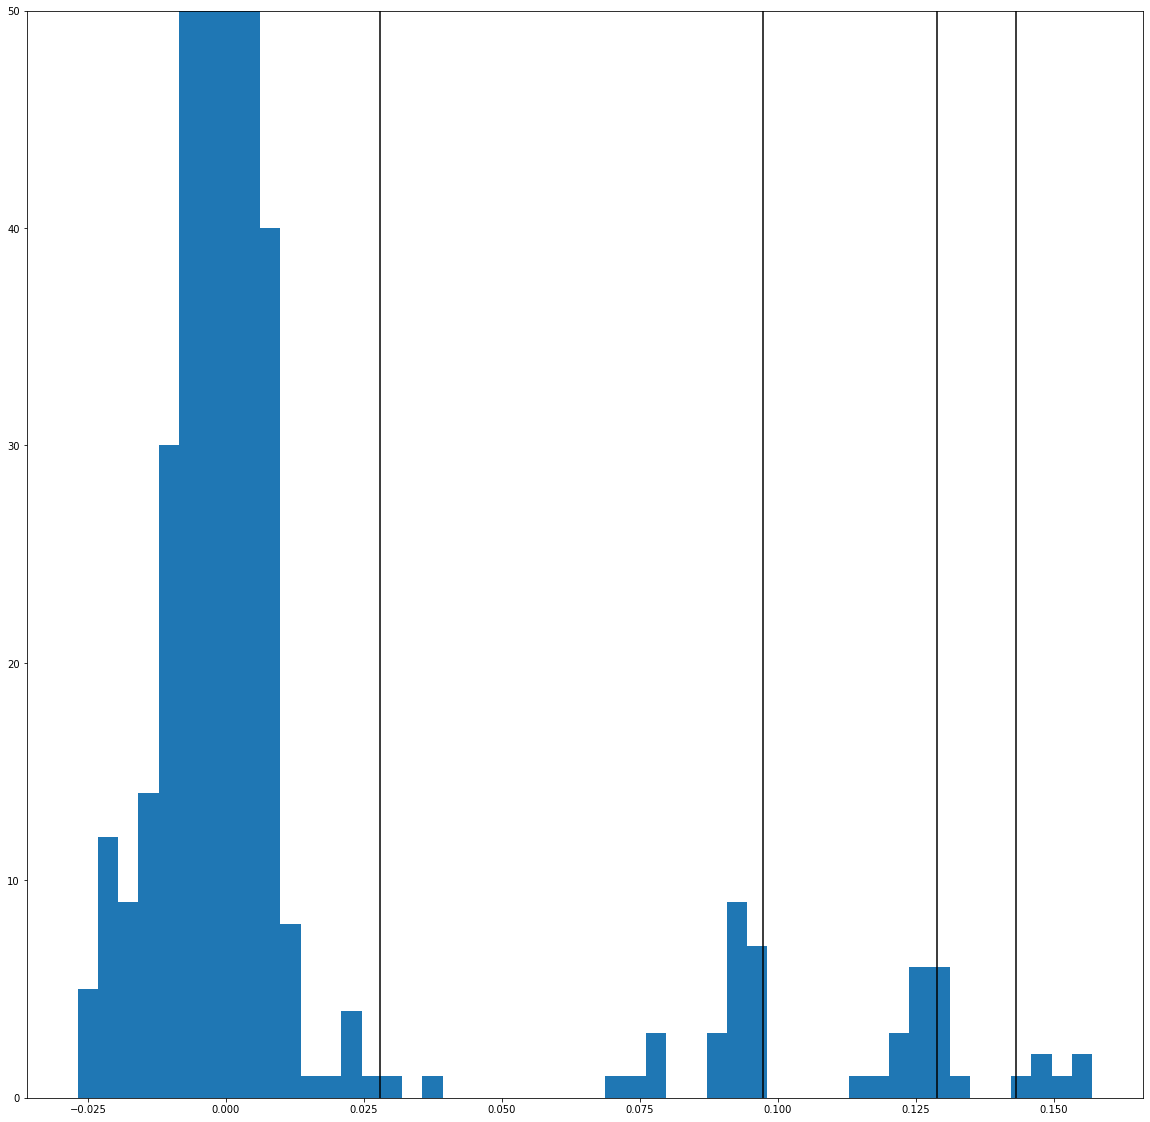

In [19]:
corr_values = np.reshape(correlation_map, -1)
corr_values = np.sort(corr_values)[::-1]
Ns = [5, 10, 25, 50]

plt.ylim(0, 50)
plt.hist(corr_values, bins=50);
plt.vlines(corr_values[Ns], 0, 50, colors='black')